# Clinical Data Quest  

### Description:  
You're a data analyst at a large healthcare organization, and your team has been tasked with analyzing patient outcomes and hospital resource utilization. Your hospital has implemented a new electronic health record (EHR) system, and you've been given access to a large dataset containing patient information, diagnoses, treatments, and outcomes. Your goal is to extract insights from this data to inform quality improvement initiatives and optimize resource allocation.

### Tasks:
- **Patient Outcome Analysis:** Calculate the average length of stay for patients with different diagnoses.
- **Resource Utilization:** Determine the most common treatments prescribed for patients with a specific diagnosis (e.g., diabetes) and calculate the total cost of these treatments.
- **Quality Improvement:** Identify patients who were readmitted within 30 days of discharge and analyze the most common reasons for readmission.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.2.1
Numpy version 1.26.4


# The Data  

The dataset contains patient information, including demographics, diagnoses, treatments, outcomes, length of stay, and costs, as well as readmission data for patients who were readmitted within 30 days of discharge. This dataset represents a realistic scenario for a large healthcare organization, with a mix of categorical and numerical data.  

### Columns:  
- **Patient ID:** Unique identifier for each patient
- **Age:** Patient age in years
- **Diagnosis:** Primary diagnosis for each patient
- **Treatment:** Primary treatment prescribed for each patient
- **Outcome:** Outcome for each patient (discharged, readmitted, or deceased)
- **Length of Stay:** Number of days each patient stayed in the hospital
- **Cost:** Total cost of treatment for each patient
- **Readmission Reason:** Reason for readmission (if applicable)

In [2]:
# set the seed
np.random.seed(0)

# generate patient data
patient_data = pd.DataFrame({
    'Patient ID': np.arange(1, 10001),
    'Age': np.random.randint(18, 90, size=10000),
    'Diagnosis': np.random.choice(['Diabetes', 'Heart Failure', 'Pneumonia', 'Cancer', 'Stroke'], size=10000),
    'Treatment': np.random.choice(['Medication', 'Surgery', 'Physical Therapy', 'Chemotherapy', 'Radiation'], size=10000),
    'Outcome': np.random.choice(['Discharged', 'Readmitted', 'Deceased'], size=10000),
    'Length of Stay': np.random.randint(1, 30, size=10000),
    'Cost': np.random.randint(1000, 10000, size=10000)
})

# generate readmission data
readmission_data = pd.DataFrame({
    'Patient ID': np.random.choice(patient_data['Patient ID'], size=2000, replace=False),
    'Readmission Reason': np.random.choice(['Complication', 'Infection', 'Non-compliance', 'Other'], size=2000)
})

Let us look at the two dataframes we created above to make sure the data types are correct.

In [3]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Patient ID      10000 non-null  int32 
 1   Age             10000 non-null  int32 
 2   Diagnosis       10000 non-null  object
 3   Treatment       10000 non-null  object
 4   Outcome         10000 non-null  object
 5   Length of Stay  10000 non-null  int32 
 6   Cost            10000 non-null  int32 
dtypes: int32(4), object(3)
memory usage: 390.8+ KB


Remember, the data type named "object" is a catch-all data type for columns that contain mixed data types or data that can't be represented by other dtypes, such as:  
- Strings
- Lists
- Dictionaries
- Other objects

The "Readmission Reason" column in the dataframe below contains strings.

In [4]:
readmission_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Patient ID          2000 non-null   int32 
 1   Readmission Reason  2000 non-null   object
dtypes: int32(1), object(1)
memory usage: 23.6+ KB


# Patient Outcome Analysis:  

Calculate the average length of stay for patients with different diagnoses.  

The data indicates that heart failure patients have the longest average length of stay.

In [5]:
# create group object
group = patient_data.groupby('Diagnosis')

# get the average length of stay for group
group['Length of Stay'].mean()

Diagnosis
Cancer           15.043435
Diabetes         14.959919
Heart Failure    15.250129
Pneumonia        14.859920
Stroke           14.989289
Name: Length of Stay, dtype: float64

# Resource Utilization:  

Determine the most common treatments prescribed for patients with a specific diagnosis (e.g., diabetes) and calculate the total cost of these treatments.

In [6]:
# create group object
group = patient_data.groupby(['Diagnosis','Treatment'])

# get the counts
all = group.count()['Cost'].reset_index(name='Count').sort_values(by=['Diagnosis','Count'], ascending=False)

# get the top 2 treatments per Diagnosis
top2 = all.groupby(['Diagnosis']).head(2).reset_index(drop=True)
top2

,Diagnosis,Treatment,Count
0,Stroke,Physical Therapy,436
1,Stroke,Radiation,426
2,Pneumonia,Medication,414
3,Pneumonia,Radiation,413
4,Heart Failure,Physical Therapy,414
5,Heart Failure,Radiation,391
6,Diabetes,Chemotherapy,408
7,Diabetes,Radiation,404
8,Cancer,Surgery,438
9,Cancer,Medication,416


Now that we have the most common treatements per diagnosis. Let us join this dataset with the original patient_data dataset. This will ensure we filter our data to only include the top 2 treatments and then we can get the total cost.  

**Note:** I choose to extract the top 2 treatments to show you the code to accomplish this data wrangling technique.

In [7]:
# filter data to only include top2
filtered = patient_data.merge(top2, left_on=['Diagnosis','Treatment'], right_on=['Diagnosis','Treatment'])

# create group object
group = filtered.groupby(['Diagnosis','Treatment'])

# get total cost
group['Cost'].sum()

Diagnosis      Treatment       
Cancer         Medication          2343712
               Surgery             2407609
Diabetes       Chemotherapy        2252451
               Radiation           2274558
Heart Failure  Physical Therapy    2233649
               Radiation           2137515
Pneumonia      Medication          2183974
               Radiation           2249833
Stroke         Physical Therapy    2463359
               Radiation           2359345
Name: Cost, dtype: int32

# Quality Improvement:  

Identify patients who were readmitted within 30 days of discharge and analyze the most common reasons for readmission.  

We will make the join on the common column named "Patient ID" and do a left join. The reason is that by default Pandas will do an inner join and only return the rows where the two dataframes have matching Patient IDs. We want to inlcude all of the rows in patient_data, even if they don't have a matching Patient ID on the other dataframe. 

In [8]:
# join the two dataframes to get the readmission data
new_df = patient_data.merge(readmission_data, on='Patient ID', how='left')
new_df

,Patient ID,Age,Diagnosis,Treatment,Outcome,Length of Stay,Cost,Readmission Reason
0,1,62,Cancer,Chemotherapy,Deceased,11,5334,NaN
1,2,65,Heart Failure,Chemotherapy,Readmitted,2,9276,NaN
2,3,82,Stroke,Medication,Readmitted,1,2093,NaN
3,4,85,Cancer,Radiation,Discharged,23,5313,NaN
4,5,85,Diabetes,Surgery,Discharged,27,4569,NaN
...,...,...,...,...,...,...,...,...
9995,9996,53,Diabetes,Surgery,Discharged,25,2347,NaN
9996,9997,82,Heart Failure,Radiation,Deceased,24,9782,NaN
9997,9998,45,Heart Failure,Chemotherapy,Deceased,1,4896,NaN
9998,9999,32,Stroke,Surgery,Discharged,6,9465,NaN


We can now filter the data and visualize it.  

**note:** Since the readmission_data dataset did not provide us with any dates, I used the "length of stay". 

In [9]:
# identify all the rows that had a length of stay within 30 days
within_30_days = new_df['Length of Stay'] < 30

# identify all of the rows that had a readmission reason
readmission = new_df['Readmission Reason'].notnull()

# filtered data
final = new_df[within_30_days & readmission]
final.head()

,Patient ID,Age,Diagnosis,Treatment,Outcome,Length of Stay,Cost,Readmission Reason
37,38,52,Cancer,Radiation,Readmitted,7,1595,Infection
41,42,71,Diabetes,Medication,Readmitted,4,6443,Other
52,53,75,Stroke,Surgery,Deceased,25,8388,Infection
53,54,53,Diabetes,Physical Therapy,Deceased,23,8769,Complication
54,55,29,Diabetes,Medication,Readmitted,25,6392,Complication


Here is a simple bar chart that shows that the most common reason for readmission was "Non-compliance". 

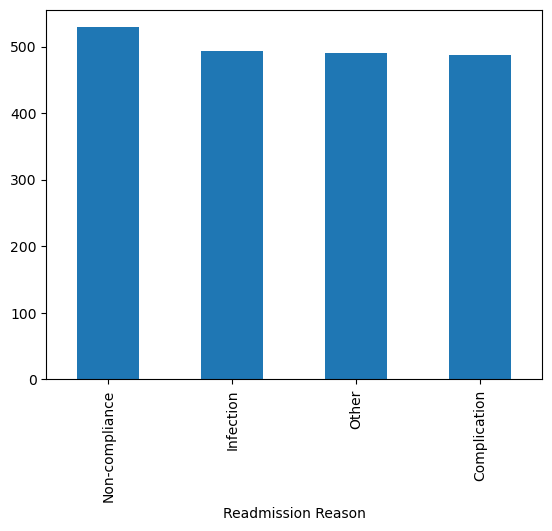

In [10]:
final['Readmission Reason'].value_counts().plot.bar();

# Summary

This tutorial walked you through a clinical data analysis project where we analyzed patient outcomes and hospital resource utilization using a sample dataset. We performed various data analysis tasks, including calculating the average length of stay for patients with different diagnoses, identifying the most common treatments and their costs, and determining the reasons for readmission within 30 days of discharge. Our analysis revealed that heart failure patients had the longest average length of stay, and non-compliance was the most common reason for readmission.

### Key Takeaways:
- How to group data by diagnosis and calculate average length of stay
- How to filter data to include only top treatments per diagnosis and calculate total cost
- How to join two dataframes on a common column (Patient ID) and perform a left join
- How to filter data to include only patients readmitted within 30 days and analyze readmission reasons
- How to create a simple bar chart to visualize readmission reasons using Pandas and Matplotlib

<p class="text-muted">This tutorial was created by <a href="https://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>